In [1]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [4]:
path_to_dataset = '/content/drive/MyDrive/Seq2Seq/balanced_data.csv'
df = pd.read_csv(path_to_dataset)
print(df.shape)

(125382, 2)


In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = sentence.replace("¿", "").replace("?", "").replace("©", "")
    sentence = sentence.replace(".", "").replace(",", "").replace("!", "").replace("¡", "")
    return sentence

In [6]:
df['english'] = df['english'].apply(preprocess_sentence)
df['spanish'] = df['spanish'].apply(preprocess_sentence)


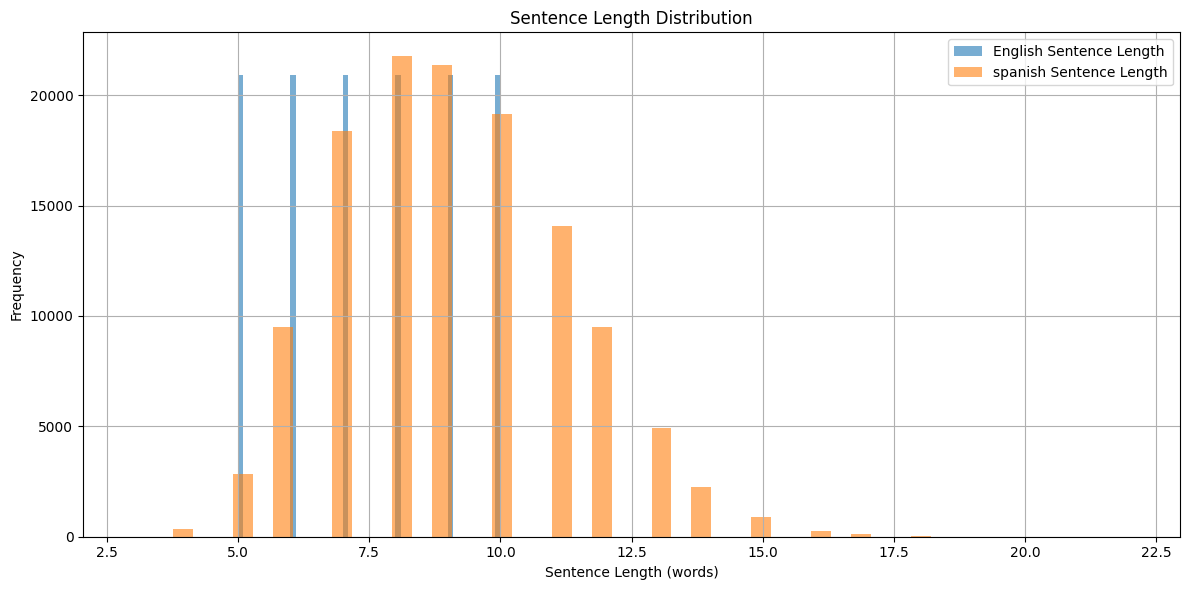

In [27]:
# Compute sentence lengths
df['english_len'] = df['english'].apply(lambda x: len(x.split()))
df['spanish_len'] = df['spanish'].apply(lambda x: len(x.split()))

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(df['english_len'], bins=50, alpha=0.6, label='English Sentence Length')
plt.hist(df['spanish_len'], bins=50, alpha=0.6, label='spanish Sentence Length')
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length (words)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
df['spanish'] = df['spanish'].apply(lambda x: '<sos> ' + x + ' <eos>')

In [9]:
# Tokenization and sequencing
def data_preprocessor(sentences):
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)
    return sequences, tokenizer

english_sentences = df['english'].tolist()
german_sentences = df['spanish'].tolist()

input_sequences, source_tokenizer = data_preprocessor(english_sentences)
target_sequences, target_tokenizer = data_preprocessor(german_sentences)

In [10]:
"""# **Model Building**"""

# These are decoder inputs and targets
decoder_input_sequences = [seq[:-1] for seq in target_sequences]
decoder_target_sequences = [seq[1:] for seq in target_sequences]

num_encoder_tokens = len(source_tokenizer.word_index) + 1
num_decoder_tokens = len(target_tokenizer.word_index) + 1

# Train-test split
train_inputs, val_inputs, train_dec_in, val_dec_in, train_targets, val_targets = train_test_split(
    input_sequences, decoder_input_sequences, decoder_target_sequences, test_size=0.1, random_state=42)

In [11]:
def is_not_empty(seq):
    return len(seq) > 0 and any(token != 0 for token in seq)

# Filter empty sequences and ensure equal lengths
def filter_sequences(enc_seqs, dec_in_seqs, dec_tar_seqs):
    filtered_enc, filtered_dec_in, filtered_dec_tar = [], [], []

    for enc, dec_in, dec_tar in zip(enc_seqs, dec_in_seqs, dec_tar_seqs):
        if is_not_empty(enc) and is_not_empty(dec_in) and is_not_empty(dec_tar):
            filtered_enc.append(enc)
            filtered_dec_in.append(dec_in)
            filtered_dec_tar.append(dec_tar)

    return filtered_enc, filtered_dec_in, filtered_dec_tar

In [12]:
train_inputs, train_dec_in, train_targets = filter_sequences(train_inputs, train_dec_in, train_targets)
val_inputs, val_dec_in, val_targets = filter_sequences(val_inputs, val_dec_in, val_targets)

print(f"Training samples: {len(train_inputs)}")
print(f"Validation samples: {len(val_inputs)}")

Training samples: 112843
Validation samples: 12539


In [13]:
# Convert sequences to tf.data.Dataset
def map_func(enc_inp, dec_inp, dec_tar):
    return ({
        'encoder_inputs': enc_inp,
        'decoder_inputs': dec_inp
    }, dec_tar)

train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.ragged.constant(train_inputs),
    tf.ragged.constant(train_dec_in),
    tf.ragged.constant(train_targets)
)).map(map_func)

val_dataset = tf.data.Dataset.from_tensor_slices((
    tf.ragged.constant(val_inputs),
    tf.ragged.constant(val_dec_in),
    tf.ragged.constant(val_targets)
)).map(map_func)


In [14]:
# Applying DYNAMIC padding
BATCH_SIZE = 32
BUFFER_SIZE = 10000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE,
    padded_shapes=({
        'encoder_inputs': [None],
        'decoder_inputs': [None]
    }, [None]),
    padding_values=({
        'encoder_inputs': 0,
        'decoder_inputs': 0
    }, 0)
)

val_dataset = val_dataset.padded_batch(
    BATCH_SIZE,
    padded_shapes=({
        'encoder_inputs': [None],
        'decoder_inputs': [None]
    }, [None]),
    padding_values=({
        'encoder_inputs': 0,
        'decoder_inputs': 0
    }, 0)
)

In [15]:
embedding_dim = 128
latent_dim = 256

from tensorflow.keras.layers import Dot, Activation, Concatenate

# Inputs
encoder_inputs = Input(shape=(None,), name='encoder_inputs')
decoder_inputs = Input(shape=(None,), name='decoder_inputs')

# Embeddings
encoder_embedding = Embedding(num_encoder_tokens, embedding_dim, mask_zero=True)(encoder_inputs)
decoder_embedding = Embedding(num_decoder_tokens, embedding_dim, mask_zero=True)(decoder_inputs)

# Encoder
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Decoder
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

In [16]:
# Custom Attention Layer
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values, mask=None):

        # Expand query to match values time steps
        query_with_time_axis = tf.expand_dims(query, 2)  # (batch_size, max_length, 1, hidden_size)
        values_with_time_axis = tf.expand_dims(values, 1)  # (batch_size, 1, max_length, hidden_size)

        # Calculate attention scores
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values_with_time_axis)))

        # Removes last dimension: (batch_size, max_length, max_length)
        score = tf.squeeze(score, axis=-1)

        if mask is not None:
          # Applying large negative value to padding positions
          score += (mask * -1e9)

        # Applying softmax
        attention_weights = tf.nn.softmax(score, axis=-1)

        # Applying attention weights to values
        context_vector = tf.matmul(attention_weights, values)

        return context_vector, attention_weights


In [17]:
# Apply custom attention
attention_layer = BahdanauAttention(latent_dim)
attention_output, attention_weights = attention_layer(decoder_outputs, encoder_outputs)

# Combine and output
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_output])
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs_final = decoder_dense(decoder_concat)

# Build and compile
model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Model summary:")
model.summary()

Model summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'bahdanau_attention' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 128) │  1,390,208 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │  2,450,304 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, None,     │    394,240 │ embedding[0][0],  │
│                     │ 256), (None,      │            │ not_equal[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    394,240 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, None,     │    131,841 │ lstm_1[0][0],     │
│ (BahdanauAttention) │ 256), (None,      │            │ lstm[0][0]        │
│                     │ None, None)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 512) │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ bahdanau_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None,      │  9,820,359 │ concatenate[0][0] │
│                     │ 19143)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,581,192 (55.62 MB)

 Trainable params: 14,581,192 (55.62 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#  sample batch
for batch in train_dataset.take(1):
    print("Sample batch shapes:")
    print("Encoder input shape:", batch[0]['encoder_inputs'].shape)
    print("Decoder input shape:", batch[0]['decoder_inputs'].shape)
    print("Target shape:", batch[1].shape)
    print("Sample encoder input:", batch[0]['encoder_inputs'].numpy()[0])
    print("Sample decoder input:", batch[0]['decoder_inputs'].numpy()[0])
    print("Sample target:", batch[1].numpy()[0])

Sample batch shapes:
Encoder input shape: (32, 10)
Decoder input shape: (32, 13)
Target shape: (32, 13)
Sample encoder input: [ 44   4 742  17  56  31   1 305   0   0]
Sample decoder input: [   1  428 5543   10    7  268    0    0    0    0    0    0    0]
Sample target: [ 428 5543   10    7  268    2    0    0    0    0    0    0    0]


In [19]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
3527/3527 ━━━━━━━━━━━━━━━━━━━━ 254s 70ms/step - accuracy: 0.5126 - loss: 3.4181 - val_accuracy: 0.6968 - val_loss: 1.6913
Epoch 2/10
3527/3527 ━━━━━━━━━━━━━━━━━━━━ 245s 70ms/step - accuracy: 0.7373 - loss: 1.3852 - val_accuracy: 0.8132 - val_loss: 0.9618
Epoch 3/10
3527/3527 ━━━━━━━━━━━━━━━━━━━━ 257s 73ms/step - accuracy: 0.8468 - loss: 0.7114 - val_accuracy: 0.8635 - val_loss: 0.6974
Epoch 4/10
3527/3527 ━━━━━━━━━━━━━━━━━━━━ 253s 70ms/step - accuracy: 0.8991 - loss: 0.4382 - val_accuracy: 0.8914 - val_loss: 0.5759
Epoch 5/10
3527/3527 ━━━━━━━━━━━━━━━━━━━━ 248s 70ms/step - accuracy: 0.9296 - loss: 0.2953 - val_accuracy: 0.9070 - val_loss: 0.5178
Epoch 6/10
3527/3527 ━━━━━━━━━━━━━━━━━━━━ 259s 73ms/step - accuracy: 0.9476 - loss: 0.2162 - val_accuracy: 0.9171 - val_loss: 0.4850
Epoch 7/10
3527/3527 ━━━━━━━━━━━━━━━━━━━━ 251s 70ms/step - accuracy: 0.9588 - loss: 0.1676 - val_accuracy: 0.9239 - val_loss: 0.4690
Epoch 8/10
3527/3527 ━━━━━━━━━━━━━━━━━━━━ 261s 70ms/step - accuracy: 

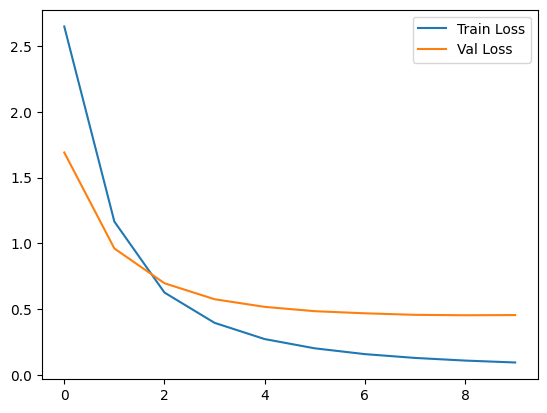

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [21]:
# model.summary()

In [22]:
# Inference models
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Decoder inference model inputs
decoder_inputs_single = Input(shape=(1,), name='decoder_input_token')
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_c')
encoder_outputs_input = Input(shape=(None, latent_dim), name='encoder_outputs_input')



# reuse trained embedding weights
decoder_embedding_inf = model.get_layer(index=3)
decoder_embedding_single = decoder_embedding_inf(decoder_inputs_single)

# LSTM step for inference
decoder_lstm_inf = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm_inf(
    decoder_embedding_single, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# Attention for inference
attention_layer_inf = attention_layer  # reuse the trained one
attention_output_inf, _ = attention_layer_inf(decoder_outputs_inf, encoder_outputs_input)

# Combine and predict
decoder_concat_inf = Concatenate(axis=-1)([decoder_outputs_inf, attention_output_inf])
decoder_dense_inf = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs_final_inf = decoder_dense_inf(decoder_concat_inf)

# Define inference decoder model
decoder_model = Model(
    inputs=[decoder_inputs_single, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
    outputs=[decoder_outputs_final_inf, state_h_inf, state_c_inf]
)


In [23]:
def translate(input_text):
    # Preprocess input
    input_seq = source_tokenizer.texts_to_sequences([input_text.lower().strip()])
    input_seq = tf.convert_to_tensor(input_seq)

    # Step 1: Get encoder outputs and initial states
    encoder_outs, state_h, state_c = encoder_model.predict(input_seq, verbose=0)

    # Step 2: Initialize decoder inputs with <sos>
    target_seq = np.array([[target_tokenizer.word_index.get('<sos>', 1)]])
    decoded_sentence = ''
    stop_condition = False

    while not stop_condition:
        # Decoder prediction
        output_tokens, h, c = decoder_model.predict([target_seq, encoder_outs, state_h, state_c], verbose=0)

        # Get token with highest probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = target_tokenizer.index_word.get(sampled_token_index, '')

        # Stop if <eos> if generated or outputs are getting too long
        if sampled_word == '<eos>' or len(decoded_sentence.split()) > 50:
            stop_condition = True
        else:
            if sampled_word and sampled_word != '<sos>':
                decoded_sentence += ' ' + sampled_word

        # Step 6: Prepare for next loop
        target_seq = np.array([[sampled_token_index]])
        state_h, state_c = h, c

    return decoded_sentence.strip()


In [24]:
# Test examples
examples = ['hello', 'how are you', 'i am fine', 'good night', 'what is your name']
for ex in examples:
    try:
        translation = translate(ex)
        print(f"{ex} -> {translation}")
    except Exception as e:
        print(f"Error translating '{ex}': {e}")

hello -> extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante extravagante
how are you -> marido marido marido marido marido reza poniéndose poniéndose poniéndose poniéndose poniéndose poniéndose poniéndose poniéndose poniéndose poniéndose poniéndose poniéndose poniéndose poniéndose poniéndose nariz poniéndose poniéndose poniéndose poniéndose poniéndose poniéndose poniéndose nariz poniéndose poniéndo

In [25]:
import sacrebleu

# Decode integer sequences back to English text
inv_source_word_index = {v: k for k, v in source_tokenizer.word_index.items()}
inv_target_word_index = {v: k for k, v in target_tokenizer.word_index.items()}

def decode_sequence(seq, inv_map):
    return ' '.join([inv_map.get(idx, '') for idx in seq if idx != 0])

# Taking only first 100 samples from validation set
sample_val_inputs = val_inputs[:100]
sample_val_targets = val_targets[:100]

# Convert validation input sequences to raw English
raw_val_inputs = [decode_sequence(seq, inv_source_word_index) for seq in sample_val_inputs]

# Convert target output sequences to raw Spanish
raw_val_refs = [decode_sequence(seq, inv_target_word_index).replace('<sos>', '').replace('<eos>', '').strip() for seq in sample_val_targets]

# Generate model predictions
predictions = []
for sentence in raw_val_inputs:
    try:
        pred = translate(sentence)
        predictions.append(pred)
    except:
        predictions.append("")


references = [[ref] for ref in raw_val_refs]  # List of lists


In [26]:
bleu = sacrebleu.corpus_bleu(predictions, references)
print(f"BLEU score: {bleu.score:.2f}")

BLEU score: 0.71
